In [23]:
import tensorflow as tf
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline  

Load the Penn Tree Bank (PTB) dataset

In [64]:
def read_txt(path):
    with open('simple-examples/data/'+path,'r') as f:
        txt = f.read().replace('\n',' ').split()
        return txt

In [65]:
train = read_txt('ptb.train.txt')
valid = read_txt('ptb.valid.txt')
test = read_txt('ptb.test.txt')

In [66]:
vocabulary = Counter(train)

In [67]:
V = len(vocabulary)

In [68]:
word2id = dict(zip(vocabulary.keys(),range(V)))

In [69]:
id2word = dict(zip(range(V),vocabulary.keys()))

In [70]:
np.all([id2word[word2id[v]] == v for v in vocabulary])

True

In [71]:
words2ids = lambda words: [word2id[w] for w in words]

In [72]:
trainNum = words2ids(train)
validNum = words2ids(valid)
testNum = words2ids(test)

In [105]:
words,counts = zip(*vocabulary.iteritems())

In [106]:
p = [vocabulary[v]*1.0/len(train) for v in vocabulary.keys()]

In [107]:
# entropy
-np.sum(p * np.log(p))

6.6457861131858875

In [108]:
# init for bias. SPEED UP TRAINING A LOT!!
b0 = np.log(p,dtype=np.float32)

In [77]:
def batch_iterator(txt,batch_size,seq_len,random):
    N = len(txt)
    batch_tot_len = N/batch_size
    bounds = np.arange(batch_size) * batch_tot_len 
    starts = np.array([np.random.randint(i,min(N,i+batch_tot_len)) for i in bounds]) if random else bounds
    while np.all(starts+seq_len<np.minimum(bounds+batch_tot_len,N)):
        yield np.array([txt[i:i+seq_len] for i in starts],dtype=np.int32),\
                np.array([txt[i+1:i+seq_len+1] for i in starts],dtype=np.int32)
        starts += seq_len

<br>

Build Computation Graph in Tensorflow

In [560]:
batch_size = 20
seq_len = 15
cells_dim = 256
n_layers = 2
learning_rate = 1e-1
grad_clip = 5.0
epoch = 1000

In [561]:
tf.reset_default_graph()

In [562]:
X = tf.placeholder(tf.int32, [batch_size, seq_len], name='X')
Y = tf.placeholder(tf.int32, [batch_size, seq_len], name='Y')
keep_prob = tf.placeholder(tf.float32,[])

In [563]:
embedding = tf.get_variable("embedding", [V, cells_dim],initializer=tf.contrib.layers.xavier_initializer())

In [564]:
X_embed = tf.nn.embedding_lookup(embedding,X)

In [565]:
X_list = tf.unstack(X_embed,axis=1)

In [566]:
cell = tf.contrib.rnn.DropoutWrapper(tf.contrib.rnn.GRUCell(cells_dim),keep_prob)

In [567]:
cell = tf.contrib.rnn.MultiRNNCell([cell]*n_layers)

In [568]:
init_state = cell.zero_state(batch_size,tf.float32)

In [569]:
outputs, state = tf.contrib.rnn.static_rnn(cell,X_list,init_state)

In [570]:
outputs_flat = tf.stack(outputs,1)

In [571]:
with tf.variable_scope('prediction'):
    W = tf.get_variable(
        "W",
        shape=[cells_dim, V],
        initializer=tf.contrib.layers.xavier_initializer())
    b = tf.get_variable(
        "b",
        initializer=tf.constant(b0))

In [572]:
yhat = tf.einsum('blc,cd->bld',outputs_flat,W) + b

In [573]:
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=Y,logits=yhat))

In [574]:
#optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
#train_op = optimizer.apply_gradients([(tf.clip_by_value(g,-grad_clip,grad_clip),v) 
#                                      for g,v in optimizer.compute_gradients(loss)])
tvars = tf.trainable_variables()
grads, _ = tf.clip_by_global_norm(tf.gradients(loss, tvars),grad_clip)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
train_op = optimizer.apply_gradients(zip(grads, tvars))

In [575]:
# build graph for sampling
# input_sample = tf.placeholder(tf.int32, [batch_size], name='input_sample')
# state_sample = cell.zero_state(batch_size,tf.float32)
input_sample = tf.placeholder(tf.int32, [None], name='input_sample')
state_sample = tuple([tf.placeholder(tf.float32, [None]+i.shape.as_list()[1:])\
                 for i in cell.zero_state(batch_size,tf.float32)])

In [576]:
pred_sample, state_out_sample = cell(tf.nn.embedding_lookup(embedding,input_sample),state_sample)

In [577]:
pred_sample = tf.nn.softmax(tf.matmul(pred_sample,W)+b)

In [578]:
def sample(state0,input0,step):
    # logP gives log prob of generated sentence
    # output is a matrix of generated sentence with shape [step,batch]
    n = input0.shape[0]
    def normalize(x):
        # due to rounding error some of sum(p)==1.000001
        return x/np.sum(x)*0.999999
    output = [[id2word[input_] for input_ in input0]]
    logP = np.zeros(n)
    for i in range(step):
        pred_np, state0 = sess.run([pred_sample, state_out_sample],\
                                        {input_sample:input0,state_sample:state0,keep_prob:1})
        input0 = [np.argmax(np.random.multinomial(1,normalize(p))) for p in pred_np]
        output.append([id2word[input_] for input_ in input0])
        logP += np.log(pred_np[range(n),input0])
    return np.array(output),logP

In [579]:
def apply2tuple(fun,tuple_):
    return tuple([fun(t) for t in tuple_])
def topK(x,k):
    x = x.flatten()
    args = np.argpartition(x, -k)[-k:]
    return args, x[args]
def indexSwitch(args,d):
    return [(a//d,a%d) for a in args]

In [580]:
def beamSearch(state0,input0,step,beamSize):
    outputs = [[id2word[input0[0]]]*beamSize]
    pred_np, state0 = sess.run([pred_sample, state_out_sample],\
                                    {input_sample:input0,state_sample:state0,keep_prob:1})  
    state0 = apply2tuple(lambda x:np.broadcast_to(x,[beamSize]+list(x.shape[1:])),state0)
    input0,logP = topK(np.log(pred_np),beamSize)
    logP = np.reshape(logP,[-1,1])
    outputs.append([id2word[i] for i in input0])
    d = pred_np.shape[1]
    
    for i in range(step-1):
        pred_np, state0 = sess.run([pred_sample, state_out_sample],\
                                        {input_sample:input0,state_sample:state0,keep_prob:1})     
        logP = logP + np.log(pred_np)
        index_,logP = topK(logP,beamSize)
        logP = np.reshape(logP,[-1,1])
        state_index,input0 = zip(*indexSwitch(index_,d))
        state0 = apply2tuple(lambda x:np.array([x[j] for j in state_index]),state0)
        outputs.append([id2word[j] for j in input0])
    
    return outputs,logP/step

In [550]:
#state0,input0,step,beamSize = apply2tuple(lambda x:x[17:18],init_state_np),Y_np[17:18,-1],30,10

In [551]:
#

<br> 

Training

In [581]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [584]:
for i in range(epoch):
    init_state_np = [np.zeros(init_.shape.as_list()) for init_ in init_state]
    loss_train = 0
    loss_val = 0
    for X_np,Y_np in batch_iterator(trainNum,batch_size,seq_len,True):
        _,init_state_np = sess.run([train_op,state],\
                                          {X:X_np,Y:Y_np,init_state:init_state_np,keep_prob:0.5})

    if i%100 == 0:
        init_state_np = [np.zeros(init_.shape.as_list()) for init_ in init_state]
        loss_train = 0
        loss_val = 0
        for j,(X_np,Y_np) in enumerate(batch_iterator(trainNum,batch_size,seq_len,False)):
            _,loss_j,init_state_np = sess.run([train_op,loss,state],\
                                              {X:X_np,Y:Y_np,init_state:init_state_np,keep_prob:0.5})
            loss_train += loss_j
        loss_train /= j

        init_state_np = [np.zeros(init_.shape.as_list()) for init_ in init_state]
        for j,(X_np,Y_np) in enumerate(batch_iterator(validNum,batch_size,seq_len,False)):
            loss_j,init_state_np = sess.run([loss,state],\
                                            {X:X_np,Y:Y_np,init_state:init_state_np,keep_prob:1})
            loss_val += loss_j
        loss_val /= j   

        print "Train loss:{}, Val loss:{}".format(loss_train,loss_val)


Train loss:6.64664176513, Val loss:6.66929807215
Train loss:6.08294783987, Val loss:6.06627306775
Train loss:5.62807354364, Val loss:5.6894725877
Train loss:5.41026022953, Val loss:5.51483056892
Train loss:5.24682989175, Val loss:5.39557820711
Train loss:5.13030031173, Val loss:5.32074147208
Train loss:5.0438444433, Val loss:5.27096486092
Train loss:4.95597624351, Val loss:5.22424374686
Train loss:4.89249222304, Val loss:5.19757680608
Train loss:4.82950742026, Val loss:5.1690716662


<br> 

Sampling from trained model

In [613]:
sample_result,logP = sample(init_state_np,Y_np[:,-1],100)

In [592]:
" ".join(sample_result[:,np.argmax(logP)].tolist())

"out <unk> of the professionals and the <unk> and the trade bill the troubles returned to be reached in analysts said takeover problems is more likely to stay <unk> a spokesman noted that a financial labor department has n't been rated pushed any sudden focus on the ual mercantile exchange closed offering in contrast copper and that await a short of the current term issues traders said that investors can report whether the rates toll for the facility last week a trade group georgia-pacific said but general co. runs a write-off of $ N million gm closed friday third-quarter average yesterday"

(array([ 2.,  4.,  7.,  4.,  1.,  1.,  0.,  0.,  0.,  1.]),
 array([-5.93002686, -5.66519238, -5.40035791, -5.13552343, -4.87068895,
        -4.60585448, -4.34102   , -4.07618552, -3.81135105, -3.54651657,
        -3.28168209]),
 <a list of 10 Patch objects>)

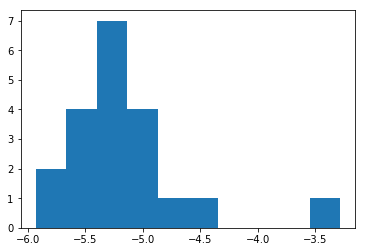

In [614]:
plt.hist(logP/100)

Beam Search finds sentence with a lot of the UNK tokens. As indicated by the average log probability, beam search does finds sentence with higher probability.

In [616]:
outputs,logP= beamSearch(apply2tuple(lambda x:x[7:8],init_state_np),Y_np[7:8,-1],30,10)

In [617]:
logP

array([[-1.71813667],
       [-1.71448636],
       [-1.71206152],
       [-1.70764816],
       [-1.69857132],
       [-1.70550406],
       [-1.7016685 ],
       [-1.70478404],
       [-1.69957519],
       [-1.69856513]], dtype=float32)

In [618]:
np.array(outputs)[:,np.argmax(logP)]

array(['tenure', 'the', 'the', 'house', '<unk>', 'the', 'house', '<unk>',
       '<unk>', '<unk>', 'and', '<unk>', 'and', '<unk>', '<unk>', '<unk>',
       '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', 'and', '<unk>',
       '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>',
       '<unk>'], 
      dtype='|S10')